In [3]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_excel

In [2]:
### Parameters #################################################################
# scales: tons, years, MXNia, hours, trips
tmax = 27 # model run, years
b1 = 41.750 # isotherm depth
b2 = -5.696 # isotherm depth
b3 = 16.397 # isotherm depth
n1 = -22.239 # ML, slope
n2 = 49.811 # ML, intersect
l1 = -0.0028 # q, slope
l2 = 0.1667 # q, intersect
a1 = 1/3.4E7 # proportion of migrating squid, where 3.4E7 max(e^(tau-b1))
g = 1.4 # population growth rate
K = 1208770 # carrying capacity in t
m = 5492603.58 # cost per unit of transport all boats, MXN/trip
f = 40 # l of fuel per trip
B_h = 7.203 # hours per fisher
B_f = 2 # fisher per panga
h1 = 2E-10 # scale E
h2 = 0.6596 # scale E
gamma = 49200 # maximum demand, t
beta = 0.0736 # slope of demand-price function
c_p = 1776.25 # cost of processing, MXNia/t
w_m = 13355164 # min wage per hour all fleet
flag = 3 # this gives an error if its not been changed previously to the right model

### Variables ##################################################################
tau = np.zeros(tmax) # temperature
q = np.zeros(tmax) # catchability squid population
ML = np.zeros(tmax) # mantle length
y_S = np.zeros(tmax) # distance of squid migration from initial fishing grounds
R_tt = np.zeros(tmax) # trader cooperation
S = np.zeros(tmax) # size of the squid population
c_t = np.zeros(tmax) # cost of transport
Escal = np.zeros(tmax) # scale effort
E = np.zeros(tmax) # fishing effort
C = np.zeros(tmax) # squid catch
p_e = np.zeros(tmax) # export price
p_escal = np.zeros(tmax) # export price
p_min = np.zeros(tmax) # minimum wage
p_f = np.zeros(tmax) # price for fishers
R = np.zeros(tmax) # revenue of fishers

### Initial values #############################################################
tau[0] = 42. # temperature
q[0] = 0.01 # squid catchability
y_S[0] = 0.5 # proportion of migrated squid
R_tt[0] = 0.5 # trader cooperation
S[0] = 1208770 # size of the squid population
c_t[0] = m *g # fleet cost of transport
E[0] = 1. # fishing effort
C[0] = 120877 # squid catch
p_e[0] = 164706 # max p_e comtrade
p_f[0] = 15438 # max p_f datamares
R[0] = C[0] *p_f[0] -(c_t[0] + E[0])


In [3]:
#### Model w/o relationships ###################################################
flag = 1 # 0 = NoR model; 1 = Rmodel

#### Load dataset  #############################################################
df1 = read_excel('./DATA/R3_data.xlsx', sheet_name='Sheet1')
#! load columns
y = df1['year'] #
pe = df1['pe_MXNiat'] #
pf = df1['pf_MXNiat'] #
ct = df1['C_t'] #
ssh = df1['essh_avg'] #
ml = df1['ML'] #
ys = df1['y_S'] #

### New max time
tmax = len(y)

The important parameters are $b_1, b_2, b_3, \beta, c_p, g, \gamma, m$ and $w_m$, which are a part of the following equations (and a few smaller additions):
\begin{align}
\tau(t) &= b_1+b_2\cos(t)+b_3\sin(t)\\
y_S(t) &= a_1\exp(\tau(t)-b_1) \\
p_e(t) &= \gamma C(t)^{-\beta}\\
S(t) &= S(t-1) +g S(t-1) \left(1-\frac{S(t-1)}{K}\right) - q(t-1) E(t-1) S(t-1)\\
c_t(t) &= mf\\
p_f(t) &= p_e(t) -c_p\\
p_{min}(t) &= \frac{E(t) w_m}{C(t)}\\
p_f(t) &= (p_e(t) -c_p)(1-R_tt(t)) +R_{tt}(t) p_{min}(t)
\end{align}

Most everything therefore is linear other than $p_e$, making this fine for Mosek or Ipopt, so long as we can identify a good objective.

---

Yep, if I follow the logic correctly: $p_f$ is effectively all that's plotted in the first graph against a set of data `PrAll = df2['priceMXNia_DM']`. 

We can minimise `np.abs(p_f - PrAll)`

In [ ]:
### Define Model ###############################################################
def model(b1, b2, b3, n1, n2, l1, l2, a1, g, K, m, f, B_h, B_f, h1, h2, gamma, beta, c_p, w_m, flag):
    for t in np.arange(1,tmax):
        # isotherm depth
        tau[t]= b1 +b2 *np.cos(t) + b3 *np.sin(t)
        # mantle length and catchability
        if ml[t] == 1:
            q[t]= l1 *tau[t] +l2
        else:
            ML[t]= ml[t]
            q[t]= 0.0018 *ML[t] - 0.0318

        # migration of squid
        if ys[t] == 1:
            y_S[t] = a1 *np.exp(tau[t]-b1)
        else:
            y_S[t]= ys[t]
        if y_S[t] > 1:
            y_S[t] = 1
            #print("yS high")
        elif y_S[t] < 0:
            y_S[t] = 0
            #print("yS low")

        # trader cooperation
        R_tt[t] = (1-y_S[t])
        # squid population
        S[t] = S[t-1] +g *S[t-1] *(1- (S[t-1]/K)) - q[t-1] *E[t-1] *S[t-1]
        # cost of transport
        c_t[t]= m *f # I decided to use fixed costs over migration, that equally well/better predicted catches over m* (y_S[t]); (source: LabNotesSquid, April 11)
        # fishing effort
        Escal[t] = E[t-1] + p_f[t-1] *q[t-1] *E[t-1] *S[t-1] -c_t[t-1] *(E[t-1]/(B_h+B_f)) # c_t is per trip so we need to upscale E hr > fisher > trip
        # fishing effort scaled
        E[t] = h1 *Escal[t] + h2 # Escal €[-3,10E+09; 1,60E+09]
        if E[t] > 1:
            E[t] = 1
            #print("E high")
        elif E[t] < 0:
            E[t] = 0
            #print("E low")

        # catch
        C[t] = q[t] *E[t] *S[t]
        # export price
        p_e[t] = gamma* (C[t])**(-beta)

        #### switch between models ####
        if flag == 0:
            # price for fishers
            p_f[t] = p_e[t] -c_p
        if flag == 1:
            # minimum wage
            p_min[t]= (E[t] *w_m)/C[t]
            # price for fishers
            p_f[t] = (p_e[t] -c_p) *(1-R_tt[t]) +R_tt[t] *p_min[t]

        # revenue of fishers
        R[t] = C[t] *p_f[t] - c_t[t-1] *(E[t-1]/(B_h+B_f))

       # print(t, tau[t], ML[t], q[t], y_S[t], S[t], c_t[t], E[t], C[t], p_e[t], p_f[t], R[t])
    return tau, ML, q, y_S, R_tt, S, c_t, E, C, p_e, p_f, R


In [ ]:
##### Initiate arrays ##########################################################
sim = np.arange(0,100) # number of simulations
x = np.zeros(12) # set array to save parameters
par = np.zeros((sim.shape[0],x.shape[0])) # matrix to save parameter values of each simulation
cat = np.zeros((sim.shape[0],tau.shape[0])) # matrix to save catches in each time period of each simulation
pri = np.zeros((sim.shape[0],tau.shape[0])) # matrix to save prices in each time period of each simulation

##### Run the model ############################################################
for j in range(0,sim.shape[0]): # draw randomly a float in the range of values for each parameter
    # a1 = np.random.uniform(2E-08, 3E-08) # parameter ranges
    # a2 = np.random.uniform(0.2, 9E-16)
    b1 = np.random.uniform(38.750, 42.1)
    b2 = np.random.uniform(-3.987, -6.9)
    b3 = np.random.uniform(11.478, 16.4)
    beta = np.random.uniform(0.01, 0.1)
    c_p = np.random.uniform(1000, 2148)
    g = np.random.uniform(0, 2.9)
    gamma = np.random.uniform(20000, 51000)
    # l1 = np.random.uniform(-0.0005, -0.0122)
    # l2 = np.random.uniform(0.0317, 0.7927)
    m = np.random.uniform(2368793, 8450159)
    w_m = np.random.uniform(11956952, 28108539)

    x = [a1, b1, b2, b3, beta, c_p, g, gamma, l1, l2, m , w_m]
    par[j] = x

    OUT = np.zeros(tau.shape[0])
    OUT1 = np.zeros(tau.shape[0])

    for i in np.arange(1,tmax):
            tau, ML, q, y_S, R_tt, S, c_t, E, C, p_e, p_f, R = model(b1, b2, b3, n1, n2, l1, l2, a1, g, K, m, f, B_h, B_f, h1, h2, gamma, beta, c_p, w_m, flag)
            OUT[i]= p_f[i]
            OUT1[i]= C[i]
            pri[j,i] = OUT[i]
            cat[j,i] = OUT1[i]


lowC = np.zeros(y.shape[0]) # initiate variables for 95% confidence interval
highC = np.zeros(y.shape[0])
meanC = np.zeros(y.shape[0])
lowP = np.zeros(y.shape[0])
highP = np.zeros(y.shape[0])
meanP = np.zeros(y.shape[0])

for h in range(0,y.shape[0]): # calculate the 95% confidence interval
    z = cat[:,h]
    lowC[h] = np.nanmean(z) - ((1.96 * np.nanstd(z))/np.sqrt(np.count_nonzero(~np.isnan(z))))
    highC[h] = np.nanmean(z) + ((1.96 * np.nanstd(z))/np.sqrt(np.count_nonzero(~np.isnan(z))))
    meanC[h] = np.nanmean(z)
    zeta = pri[:,h]
    lowP[h] = np.nanmean(zeta) - ((1.96 * np.nanstd(zeta))/np.sqrt(np.count_nonzero(~np.isnan(zeta))))
    highP[h] = np.nanmean(zeta) + ((1.96 * np.nanstd(zeta))/np.sqrt(np.count_nonzero(~np.isnan(zeta))))
    meanP[h] = np.nanmean(zeta);

meanP[h] = np.nanmean(zeta);
zeta = pri[:,h]
pri[j,i] = OUT[i]
OUT[i]= p_f[i]

In [ ]:
##### Save data  ###############################################################
if flag == 0:
    np.save("./DATA/R1support2_95_NoR_lowC.npy", lowC)
    np.save("./DATA/R1support2_95_NoR_highC.npy", highC)
    np.save("./DATA/R1support1_95_NoR_lowP.npy", lowP)
    np.save("./DATA/R1support1_95_NoR_highP.npy", highP)
    np.save("./DATA/R1support1_95_NoR_meanP.npy", meanP)
    np.save("./DATA/R1support1_95_NoR_meanC.npy", meanC)
if flag == 1:
    np.save("./DATA/R1support2_95_R_lowC.npy", lowC)
    np.save("./DATA/R1support2_95_R_highC.npy", highC)
    np.save("./DATA/R1support1_95_R_lowP.npy", lowP)
    np.save("./DATA/R1support1_95_R_highP.npy", highP)
    np.save("./DATA/R1support1_95_R_meanP.npy", meanP)
    np.save("./DATA/R1support1_95_R_meanC.npy", meanC)

From the looks of it, you must run this once with flag 0, once with flag 1 then once with something else. Then load all the calced data from disk to plot it..

In [4]:
NoR_pf = np.load("./DATA/timeSeriesNoR_pf.npy")
NoR_C = np.load("./DATA/timeSeriesNoR_C.npy")
highNoR_pf = np.load("./DATA/R1support1_95_NoR_highP.npy")
highNoR_C = np.load("./DATA/R1support2_95_NoR_highC.npy")
lowNoR_pf = np.load("./DATA/R1support1_95_NoR_lowP.npy")
lowNoR_C = np.load("./DATA/R1support2_95_NoR_lowC.npy")
meanNoR_C =np.load("./DATA/R1support1_95_NoR_meanC.npy")
meanNoR_P =np.load("./DATA/R1support1_95_NoR_meanP.npy")

R_pf = np.load("./DATA/timeSeriesR_pf.npy")
R_C = np.load("./DATA/timeSeriesR_C.npy")
highR_pf = np.load("./DATA/R1support1_95_R_highP.npy")
highR_C = np.load("./DATA/R1support2_95_R_highC.npy")
lowR_pf = np.load("./DATA/R1support1_95_R_lowP.npy")
lowR_C = np.load("./DATA/R1support2_95_R_lowC.npy")
meanR_C =np.load("./DATA/R1support1_95_R_meanC.npy")
meanR_P =np.load("./DATA/R1support1_95_R_meanP.npy")





### font ######################################################################
hfont = {'fontname':'DejaVu Sans'}



In [30]:
df2 = read_excel('./DATA/PriceVolDataCorrected.xlsx', sheet_name='Sheet1')
# Load columns
VolAll = df2['tons_DM']
PrAll = df2['priceMXNia_DM']
yr = np.array(df2["Year"])
tmax = len(df2['Year']);
#x = np.arange(0,len(y))

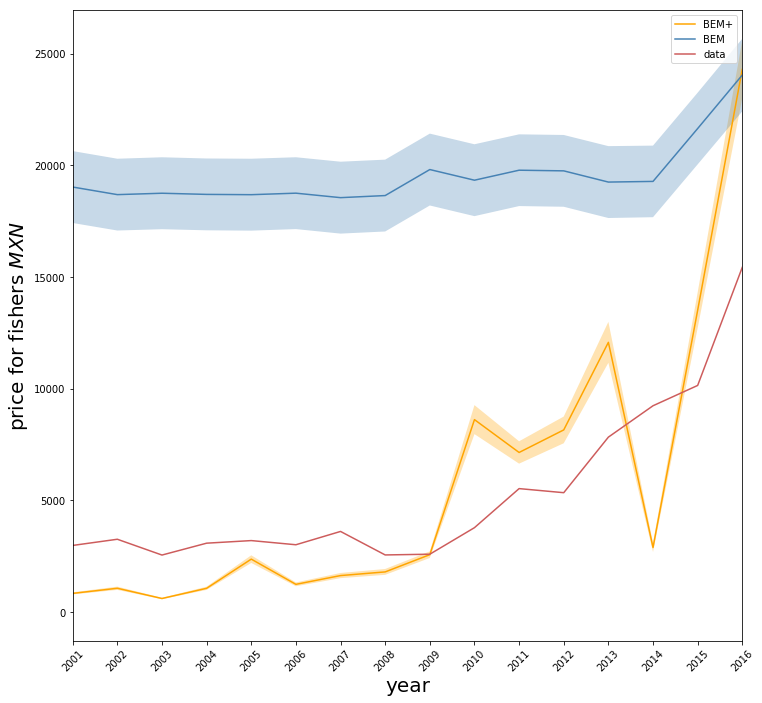

In [5]:
#####! PLOT MODEL  #############################################################
fig = plt.figure(figsize=(12,12))
a, = plt.plot(meanR_P, label = "BEM+", color="orange")
b, = plt.plot(meanNoR_P, label = "BEM", color="steelblue")
c, = plt.plot(PrAll, label = "data", color = "indianred")
plt.fill_between(x, highR_pf, lowR_pf, where = highNoR_pf >= lowNoR_pf, facecolor='orange', alpha= 0.3, zorder = 0)
plt.fill_between(x, highNoR_pf, lowNoR_pf, where = highNoR_pf >= lowNoR_pf, facecolor='steelblue', alpha= 0.3, zorder = 0)
# plt.title("Predicted and measured price for fishers [MXN]", fontsize= 25)
# x-axis
plt.xticks(np.arange(len(y)), y, rotation=45)
plt.xlim(10,tmax-2)
plt.xlabel("year",fontsize=20, **hfont)
plt.gcf().subplots_adjust(bottom=0.15)
# y-axis
plt.ylabel("price for fishers $MXN$",fontsize=20, **hfont)
plt.legend(handles=[a,b,c], loc='best')
# save and show
# fig.savefig('./Dropbox/PhD/Resources/P2/Squid/CODE/Squid/FIGS/R1_support1MC.png',dpi=500)
plt.show()

In [ ]:
fig = plt.figure(figsize=(12,12))
a, = plt.plot(meanR_C, label = "BEM+", color="orange")
b, = plt.plot(meanNoR_C, label = "BEM", color="steelblue")
c, = plt.plot(VolAll, label = "data", color= "indianred")
plt.fill_between(x, highR_C, lowR_C, where = highNoR_C >= lowNoR_C, facecolor='orange', alpha= 0.3, zorder = 0)
plt.fill_between(x, highNoR_C, lowNoR_C, where = highNoR_C >= lowNoR_C, facecolor='steelblue', alpha= 0.3, zorder = 0)
# title
# plt.title("Predicted and measured catch [t]", fontsize= 25)
# x-axis
plt.xticks(np.arange(len(y)), y, rotation=45)
plt.xlim(10,tmax-2)
plt.xlabel("year",fontsize=20, **hfont)
plt.gcf().subplots_adjust(bottom=0.15)
# y-axis
plt.ylabel("catch $tons$",fontsize=20, **hfont)
# legend
plt.legend(handles=[a,b,c], loc='best')
# save and show
# fig.savefig('./Dropbox/PhD/Resources/P2/Squid/CODE/Squid/FIGS/R1_support2MC.png',dpi=200)
plt.show()

In [40]:
from scipy import optimize
import numpy as np
import matplotlib.pyplot as plt

In [76]:
month = np.genfromtxt('monthlyfull.csv', delimiter=',', names=["time", "data"], skip_header=1)
mask = np.isnan(month["data"])
month = month[~mask]

In [13]:
year = np.genfromtxt('yearlyfull.csv', delimiter=',', names=["time", "data"], skip_header=1)
mask = np.isnan(year["data"])
year = year[~mask]

In [84]:
def temperature(t, a, b, c, w):
    return a + b * np.cos(w * t) + c * np.sin(w * t)

params, params_covariance = optimize.curve_fit(temperature, 
                                               month["time"],
                                               month["data"],
                                               p0=[42.59,0.1,30,3.5],
                                               maxfev = 10000)

print(params)
print(params_covariance)

[ 36.53608348 -13.34228065  -4.50620585   3.53931205]
[[ 2.54903948e+01  1.28023795e+02 -3.53275771e+02  1.34552066e-02]
 [ 1.28023795e+02  9.93661693e+05 -3.08436341e+06  1.14421321e+02]
 [-3.53275771e+02 -3.08436341e+06  9.57467481e+06 -3.55190125e+02]
 [ 1.34552066e-02  1.14421321e+02 -3.55190125e+02  1.31764962e-02]]


In [15]:
from scipy.interpolate import CubicSpline

In [16]:
cs = CubicSpline(year["time"], year["data"]) 

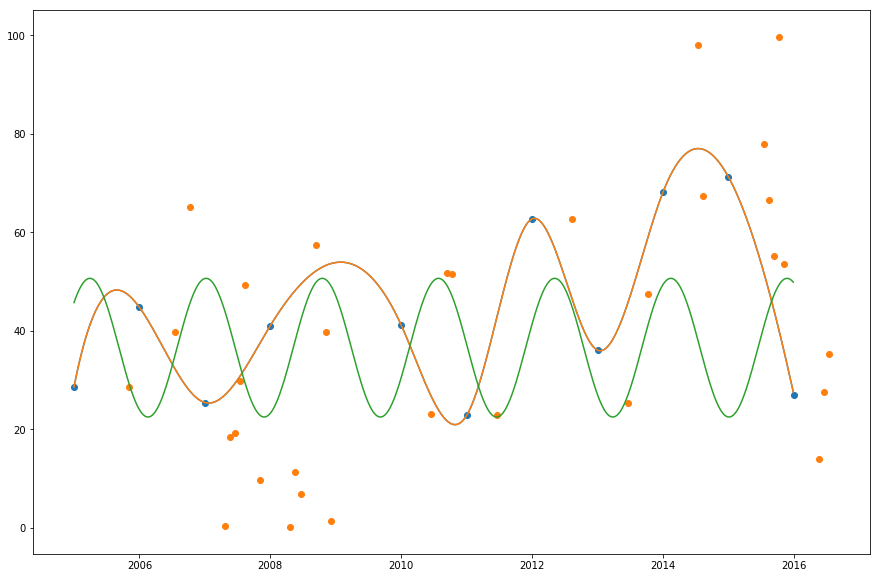

In [86]:
plt.figure(figsize=(15,10))
xint = np.arange(year["time"][0],year["time"][-1],0.01)
plt.plot(xint,cs(xint))
plt.scatter(year["time"],year["data"])
plt.scatter(month["time"],month["data"])
xall = np.arange(yr[14],yr[-2],0.01)
plt.plot(xall,cs(xall))
#plt.plot(xint, temperature(xint,42.59,0.1,30,3.5))
plt.plot(xint, temperature(xint,36.53608348, -13.34228065,  -4.50620585,   3.53931205))

In [88]:
np.mean(month["data"])

39.24755993912263

In [24]:
np.savetxt("cubic_spline.csv", cs(xint), delimiter=",")
np.savetxt("x_spline.csv", xint, delimiter=",")